# CZSa 2024 Homework 2

## Instructions

You are allowed to collaborate and to use information from slides, books, internet etc., for solving this homework. HOWEVER, in the final exam, there will be some questions that are very similar to some questions of this homework and/or the previous homework. These questions can give ten (10) points in total on the exam. Therefore, it is beneficial for you to understand the answers you provide here.

Deadline 2024-12-31 by email. Please include any code you have written either, separately or as verbatim text in the report. 

Please don't hestitate to ask if something is unclear.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## 1 Computer tasks 
A signal has been generated according to the ARX assumption, i.e., 
\begin{equation}
y[n]=\sum_{k=0}^N b_k u[n-k] + \sum_{k=1}^M a_k y[n-k] + e[n],
\end{equation}
where $a_k$ and $b_k$ are unknown parameters of an IIR filter, $e[n]\sim\mathcal{N}(\mu,\sigma^2)$ and $e[n]$ and  $e[m]$ are statistically independent for $n\ne m$.
On the e-learning portal, next to this HW, you can find the input, $u[n]$ and output $y[n]$ of two signals generated according to this process. They are generated with the same filter but with different $u[n]$ and $e[n]$. They have the subscript ```train``` and ```test``` respectively. The input/output with subscript ```train``` should be used for estimating the filter parameters and the input/output with subscript ```test``` should be used for evaluating it. This signals were originally of length 1100 but the first 100 samples have been discarded to reduce *settling in* effects.

### a) (1p)
Estimate an IIR filter that fits the signal using the method described in slide 38 of Lecture 11: *System identification with linear regression*. For this you can use the code from Exercise 11, e.g., the function ```make_mat_2``` and related calculations. Define the error, $e$, of the estimated filter as 
\begin{equation}
e=\sqrt  { \frac{1}{S} \sum_{n=0}^{999}\left(y[n]-\hat {y}[n]\right)^2 }.
\end{equation}
Plot 
- The error, $e_{\rm{train}}$, of the training signal 
- The error, $e_{\rm{test}}$, of the test signal 
- The estimation of $\hat{\sigma}=\sqrt{1/\hat{\beta}}$ as defined on slide 37,

vs. the order of the filter. 

You can assume $N=M$( i.e., the order of the numerator and denominator is the same and this is the order of the filter) and test it e.g, for values $0,\ldots,5$.

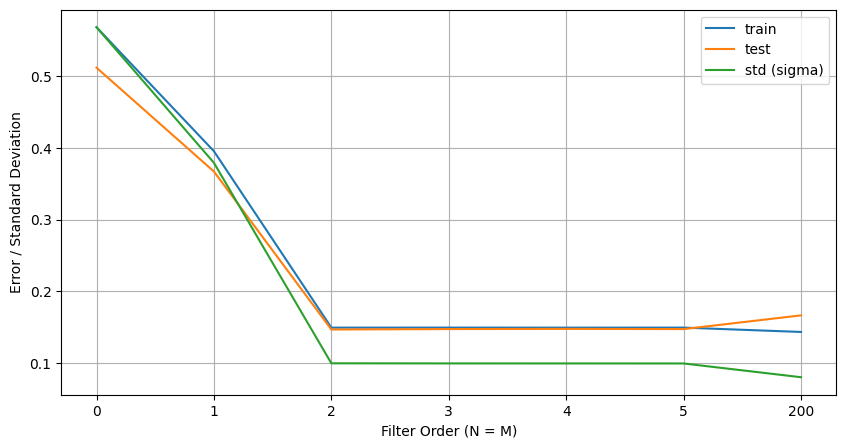

In [15]:
# Train signals loading
in_train = np.load('u_train.npy')
out_train = np.load('y_train.npy')

# Test signals loading
in_test = np.load('u_test.npy')
out_test = np.load('y_test.npy')

# Function from exercise 11 to create a matrix that relates current and past inputs and outputs
def make_mat_2(N, M, x, y):
    L_i = len(x)
    L_o = len(y)
    
    X = np.zeros((L_o, N+1))
    
    for i in range(L_i):
        for j in range(N+1):
            if (i-j)>-1:
                X[i,j]=x[i-j]
                
    Y = np.zeros((L_o, M))       
     
    for i in range(L_o):
        for j in range(M):
            if (i-1-j)>=0:
                Y[i,j]=-y[i-1-j] 
                
    return np.hstack((Y,X)) 

# Lists to store the errors, standard deviations and coefficients
train_errors = []
test_errors = []
stds = []
coeffs = []

# Orders to test - low values and a high value (to see the effect of overfitting)
orders = [0, 1, 2, 3, 4, 5, 200]

for order in orders:
    # Create the matrix X using the training data
    X_train = make_mat_2(order, order, in_train, out_train)

    # Calculate filter coefficients using least squares
    theta, residuals, _, _ = np.linalg.lstsq(X_train, out_train, rcond=None)

    # Get the filter coefficients (inspired by the code from exercise 11)
    a = np.insert(theta[:order], 0 , 1)  # explicit a_0 = 1
    b = theta[order:] 
    
    # Predict the output of both train and test recordings using the filter coefficients
    y_train_predicted = signal.lfilter(b, a , in_train)
    y_test_predicted = signal.lfilter(b, a, in_test)

    # Error calculation according to the formula provided here
    e_train = np.sqrt(np.mean((out_train - y_train_predicted) ** 2))
    e_test = np.sqrt(np.mean((out_test - y_test_predicted) ** 2))

    std = np.sqrt(residuals / len(out_train)) # residuals = sums of squared errors returned by lstsq

    train_errors.append(e_train)
    test_errors.append(e_test)
    stds.append(std)
    coeffs.append(theta)

# Errors plotting
plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='train')
plt.plot(test_errors, label='test')
plt.plot(stds, label='std (sigma)')
plt.xticks(range(len(orders)), orders)
plt.xlabel('Filter Order (N = M)')
plt.ylabel('Error / Standard Deviation')
plt.grid(True)
plt.legend()

In [16]:
min_error_idx = np.argmin(test_errors)
print(f'Minimum test error {test_errors[min_error_idx]} at order {orders[min_error_idx]}')
print(f'Coefficients: {coeffs[min_error_idx]}')

Minimum test error 0.14676416597165146 at order 2
Coefficients: [-0.50510869  0.70968798  0.29942859  0.49671576  0.2109223 ]


### b) 2p
Comment on the results.
- What is the best value of the $e_{\rm{test}}$?
  - Approximately $0.148$ for the filter of second order.
- How does $e_{\rm{train}}$ and $e_{\rm{test}}$ differ? For this question, consider also to set the order to something large like 200. If they differ, why is this the case?
  - For orders $0$ and $1$, the $e_{\rm{train}}$ is higher than the $e_{\rm{test}}$. For a very high order, the model overfits on the train recording, thus, it is not able to generalize.  
- How do $\hat{\sigma}$ and $e$ differ and why do they differ?
  - $\hat{\sigma}$ is smaller compared to $e$ as it is calculated using the X_train matrix, which includes the ground truth samples that are fed as input to the estimated recursive coefficients.
- What do you think is the order of the true filter and what is its parameters?
  - According to the minimal $e_{\rm{test}}$, the true order is most likely $2$ with following parameters: 
    ```
    #                  a1           a2           b0         b1          b2     
    Coefficients: [-0.50510869  0.70968798  0.29942859  0.49671576  0.2109223 ]
    ```

### c) 2p
Recall that the transfer function from input ($u$) and noise ($e$) to the output ($y$) for the the ARX model is
\begin{equation}
Y(z) = U(z)\frac{\sum_{k=0}^N a_k z^{-k}}{1-\sum_{k=1}^M b_k z^{-k}} + E(z)\frac{1}{1-\sum_{k=1}^M b_k z^{-k}}.
\end{equation}
Compare the power spectral density (PSD) of the output with the estimated PSD based on the input, your estimation of the noise and your estimation of the parameters for the filter. In other words, check numerically that the left side and right side of the above equation are similar. You can do this by computing the frequency response for left and right side, plot them and comfirm that the plots look similar.

**Hints:**

- Recall that the power spectral density is obtained as $\mathbb{E}\frac{1}{N}|X[k]|^2= \mathbb{E}\frac{1}{N}X[k]\overline{X[k]}$, so for the output $y[n]$, you can divide it into e.g, 10 chunks, calculate DFT for each of them, take the absolute value, then the square, then average over the chunks.
- The frequency response of $\frac{\sum_{k=0}^N a_k z^{-k}}{1-\sum_{k=1}^M b_k z^{-k}}$ and $\frac{1}{1-\sum_{k=1}^M b_k z^{-k}}$ can be obtained with the ```scipy.signal.freqz``` function or other methods shown in exercise 4. But be careful for which frequencies this function returns the frequencys response (check the documentation)
- For the right hand side, you need to calculate the frequency response of the whole expression, then compute PSD.
- The frequency response for uncorrelated (white) noise with variance 1 is 1 for all frequencies. (You may want to understand why but this is not part of the homework.)

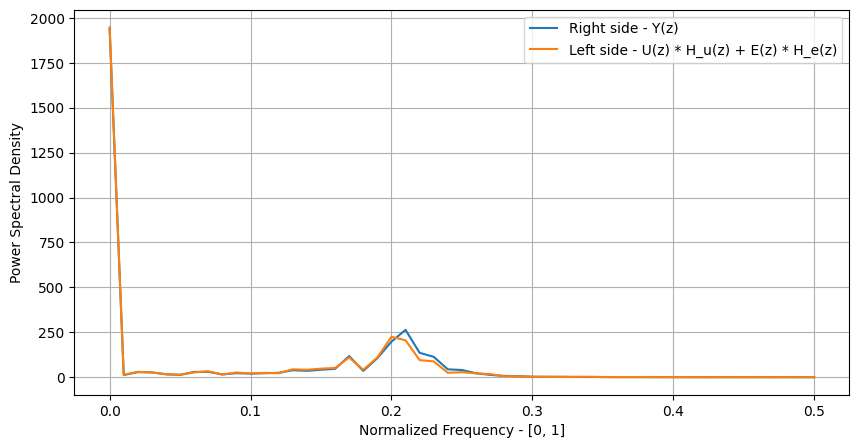

In [26]:
# Constants
CHUNKS = 10
N = len(out_train)
CHUNK_SIZE = N // CHUNKS
FFT_HALF_SIZE = (CHUNK_SIZE // 2) + 1

# Coefficients and order
order = orders[min_error_idx]
estimated_coeffs = coeffs[min_error_idx]
a = np.insert(estimated_coeffs[:order], 0 , 1)
b = estimated_coeffs[order:]

# Calculate the PSD of a signal
def psd(signal):
  # "divide it into 10 chunks"
  s_chunks = np.reshape(signal, (CHUNKS, CHUNK_SIZE))
  
  # "calculate DFT for each of them"
  chunks_spectrum = np.fft.fft(s_chunks, axis=1)[:, : FFT_HALF_SIZE] # only keep the first half of the FFT

  # "take the absolute value (get rid of complex values), then the square, then average over the chunks"
  return np.mean((chunks_spectrum * np.conj(chunks_spectrum)).real, axis=0)

# "for the right hand side, you need to calculate the frequency response of the whole expression"
in_psd = psd(in_train)
out_psd = psd(out_train)
# "the frequency response for uncorrelated (white) noise with variance 1 is 1 for all frequencies"
e_pds = np.ones((FFT_HALF_SIZE))

# Frequency response calculation
_, Hu_z = signal.freqz(b, a, worN=FFT_HALF_SIZE)
_, He_z = signal.freqz([1], a, worN=FFT_HALF_SIZE)

# For a transfer function H(z), the PSD is proportional to the square of the magnitude: PSD = |H(z)|^2 or equivalently: PSD = H(z) * H(z)^*
u_h_psd = (np.abs(Hu_z) ** 2).real # or equivalently: (Hu_z * np.conj(Hu_z)).real
e_h_psd = (np.abs(He_z) ** 2).real # or equivalently: (He_z * np.conj(He_z)).real

# Compute the left and right side of the equation
l_side = out_psd
r_side = in_psd * u_h_psd + e_pds * e_h_psd

# Plot the PSDs
x_axis = np.linspace(0, 0.5, FFT_HALF_SIZE)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, r_side, label='Right side - Y(z)')
plt.plot(x_axis, l_side, label='Left side - U(z) * H_u(z) + E(z) * H_e(z)')
plt.legend()
plt.xlabel('Normalized Frequency - [0, 1]')
plt.ylabel('Power Spectral Density')
plt.grid(True)

## 2 Pen task 

### a) 2p
Show for the Discrete Time Fourier Transform (DTFT), that convolution in the time domain leads to multiplication in the frequency domain, i.e, 
\begin{equation}
\widehat{(f*g)[n]}(\omega)=\sum_{n=-\infty}^{\infty}\sum_{k=-\infty}^{\infty}f[k]g[n-k] e^{-j\omega kT_s}
=\widehat{g[n]}(\omega)\widehat{g[n]}
\end{equation} 
where, $\widehat{\cdot}$ means application of the DTFT. 
*Hint*
First show that for a shift, we have
\begin{equation}
\widehat{g[n-k]}(\omega)= \sum_{n=-\infty}^{\infty}g[n-k]e^{-j\omega kT_s }=e^{-j\omega T_sk}\sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega n'}=\widehat{g[n]}(\omega)e^{-j\omega T_sk}.
\end{equation}

## 2 - Solution

### DTFT - Shift

The definition of the DTFT:

$$\widehat{g[n]}(\omega)= \sum_{n=-\infty}^{\infty}g[n]e^{-j\omega nT_s }$$

For the shifted signal, we get:

$$\widehat{g[n-k]}(\omega)= \sum_{n=-\infty}^{\infty}g[n-k]e^{-j\omega nT_s }$$

We can substitue $n' = n - k$, therefore, $n = n' + k$. The equation can be rewritten as:

$$\widehat{g[n-k]}(\omega)= \sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega (n'+ k)T_s } = \sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega n'T_s } e^{-j\omega kT_s }$$

The term $e^{-j\omega kT_s}$ does not depend on $n'$, thus, it can be factored out:

$$\sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega n'T_s } e^{-j\omega kT_s } = e^{-j\omega kT_s } \sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega n'T_s }$$

The conclusion is that calculating the DTFT of a negatively shifted signal is exactly the same as calculating DTFT
of a non-shifted signal and subtracting $wkT_s$ from its phase.

$$\widehat{g[n-k]}(\omega)= \widehat{g[n]}(\omega)e^{-j\omega kT_s }$$

### Convolution in time, multiplication in frequency

The definition of convolution:

$$(f*g)[n]=\sum_{k=-\infty}^{\infty}f[k]g[n-k]$$

When the DTFT is applied on the result of a convolution, we get following equation:

$$\widehat{(f*g)[n]}(\omega)=\sum_{n=-\infty}^{\infty}(\sum_{k=-\infty}^{\infty}f[k]g[n-k]) e^{-j\omega nT_s}$$

Here, however, we can change the order of sums and reorder the terms, e.g., $f[k]$ is independent of $n$:

$$\widehat{(f*g)[n]}(\omega)=\sum_{k=-\infty}^{\infty}f[k]\sum_{n=-\infty}^{\infty}g[n-k]e^{-j\omega nT_s}$$

The second part of the equation can be rewritten according to the conclusion we've come to in the first part of this proof (DTFT of shifted signal):

$$\widehat{(f*g)[n]}(\omega)=\sum_{k=-\infty}^{\infty}f[k]\widehat{g[n]}(\omega)e^{-j\omega kT_s }$$

Now, the $\widehat{g[n]}(\omega)$ becomes independent of $k$, and the rest of the term is the exact definition of the DTFT. From that, we can see that the convolution between two signals in time domain results in multiplication of their spectra. 

$$\widehat{(f*g)[n]}(\omega)=\widehat{f[n]}(\omega)\widehat{g[n]}(\omega)$$